In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Flatten,  Concatenate
from tensorflow.keras.models import Model

from sklearn.utils import shuffle

In [2]:
import requests

url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
response = requests.get(url)

In [5]:
import zipfile
import io

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    print(z.namelist())  

    with z.open('ml-20m/ratings.csv') as ratings_file:
        df = pd.read_csv(ratings_file)

print(df.head())

['ml-20m/', 'ml-20m/genome-scores.csv', 'ml-20m/genome-tags.csv', 'ml-20m/links.csv', 'ml-20m/movies.csv', 'ml-20m/ratings.csv', 'ml-20m/README.txt', 'ml-20m/tags.csv']
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580


In [16]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [17]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [18]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [11]:
N = len(set(user_ids))
M = len(set(movie_ids))
K = 10

In [19]:
u = Input(shape=(1,))

m = Input(shape=(1,))

u_emb = Embedding(N, K)(u) 

m_emb = Embedding(M, K)(m)

u_emb = Flatten()(u_emb) 
m_emb = Flatten()(m_emb) 

x = Concatenate()([u_emb, m_emb]) 

x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)

In [21]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9),
)

In [23]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]


avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [24]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, 
  validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 134s - 9ms/step - loss: 0.7656 - val_loss: 0.7166
Epoch 2/25
15626/15626 - 134s - 9ms/step - loss: 0.6994 - val_loss: 0.6957
Epoch 3/25
15626/15626 - 134s - 9ms/step - loss: 0.6784 - val_loss: 0.6829
Epoch 4/25
15626/15626 - 132s - 8ms/step - loss: 0.6635 - val_loss: 0.6733
Epoch 5/25
15626/15626 - 130s - 8ms/step - loss: 0.6537 - val_loss: 0.6684
Epoch 6/25
15626/15626 - 131s - 8ms/step - loss: 0.6419 - val_loss: 0.6613
Epoch 7/25
15626/15626 - 131s - 8ms/step - loss: 0.6256 - val_loss: 0.6518
Epoch 8/25
15626/15626 - 127s - 8ms/step - loss: 0.6107 - val_loss: 0.6419
Epoch 9/25
15626/15626 - 128s - 8ms/step - loss: 0.5999 - val_loss: 0.6370
Epoch 10/25
15626/15626 - 128s - 8ms/step - loss: 0.5908 - val_loss: 0.6343
Epoch 11/25
15626/15626 - 131s - 8ms/step - loss: 0.5826 - val_loss: 0.6335
Epoch 12/25
15626/15626 - 132s - 8ms/step - loss: 0.5752 - val_loss: 0.6336
Epoch 13/25
15626/15626 - 135s - 9ms/step - loss: 0.5686 - val_loss: 0.6271
Epoch 14/25
15626/156

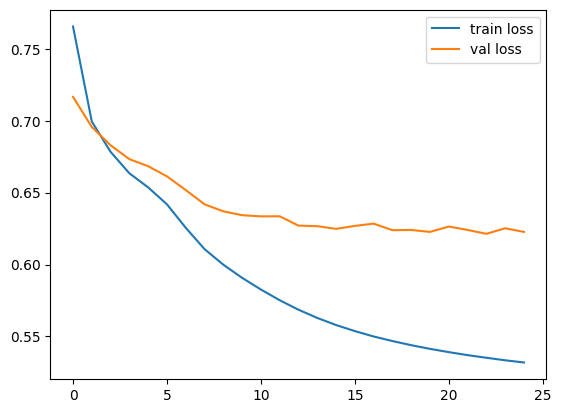

In [25]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [28]:
n = r.history['val_loss'][-1]

In [29]:
np.sqrt(n)

0.7891268562284186